# Onset Variables and Descriptive Statistics 
This notebook codes different versions of the conflict onset variable as well as a lagged dependent variable, a cumulative sum of previous onsets and a civil war dummy. These variables are subsequently saved in a new version of the dataset. This notebook also implements an initial descriptive analysis of the variables involved in the analysis. This analysis serves to get a better intuition about the variance in the data and for how to interpret the results. It also servers to rule out any oddities in the dataset that might occur due to merging issues or during the imputation of missing values.

In [1]:
### Load libraries -------
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import os
import yaml

# Pandas parameters
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', 2000)
#pd.set_option('display.max_columns', 500)

In [2]:
### Define plot parameters ------
plt.rcParams["font.family"] = "garamond"
plt.rcParams.update({'font.size': 22})
rcParams.update({'figure.autolayout': True})

In [3]:
### Define out paths ------

# check if out path exists, if it does not exists add the path
if not os.path.exists('C:\\Users\\frank\\Desktop\\master_thesis_out'):
    os.makedirs('C:\\Users\\frank\\Desktop\\master_thesis_out')

# add subfolders for the out path
out_paths = {
    "desciptive_plots_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_plots_outcome',
    "desciptive_tables_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_tables_outcome',
    "data": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data',
    "imp": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data\imp'
}

for key, val in out_paths.items():
    if not os.path.exists(val):
        os.makedirs(val)
        
out_paths["desciptive_tables_outcome"]

'C:\\Users\\frank\\Desktop\\master_thesis_out\\desciptive_tables_outcome'

In [4]:
### Open yaml file to import feature lists --------
# I specified a yaml file to import variable lists, this serves to shorten the notebook
with open('C:\\Users\\frank\\Desktop\\master_thesis\\feature_lists.yaml') as file:
    feat_list = yaml.load(file, Loader=yaml.FullLoader)

feat_rebel_visibility = feat_list["rebel_visibility"]
feat_social_networks = feat_list["social_networks_short_log"]
feat_state_capacity = feat_list["state_capacity"]
feat_natural_resources = feat_list["natural_resources_log"]

In [5]:
### Make a dictionary with fancy names of variables to import into functions  -----
dict_feat_names = {
  "foundloc_cat_cat": "Location of Rebel Group Formation to Capital",
  "terrain": "Terrain Ruggedness",
  "forest_cov": "Forest Coverage ",
  "rural": "Rural Population ",
  "oil": "Oil Rents",
  "oil_log": "Oil Rents (log)",
  "ident_ethnicity": "Ethnicity  (Identity)",
  "parent_splinter_nonstate": "Splinter Non-State (Pre-existing Organization)",
  "parent_splinter_state": "Splinter State (Pre-existing Organization)",
  "parent_civil_society": "Civil Society (Pre-existing Organization)",
  "parent_merger": "Merger (Pre-existing Organization)",
  "civil_war_dummy": "Transition to Civil War", 
  "active_year_lag": "Transition to Civil Conflict (lag)",
  "gov_qual": "Quality of Government",
  "milexp_in": "Military Expenditure Index",
  "milper_in": "Military Personnel Index",
  "polity2": "Combined Polity Score", 
  'internet_use': "Internet Usage",
  'internet_use_log': "Internet Usage (log)",
  "age_formation": "Age of Rebel Group Since Formation",
  "ideo_total": "Intensity of Ideology",
  "goal_total": "Intensity of Goals",
}

In [6]:
### Load data -----
df = pd.read_csv(os.path.join(out_paths["imp"], "df_imp_1.csv")) ### <----- change to use other imputed datasets
#df = pd.read_csv(os.path.join(out_paths["imp"], "df_imp_simple_interpolated.csv"))
df.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,parent_merger,oil,forest_cov,rural,terrain,gov_qual,milexp_in,milper_in,polity2,internet_use
0,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.0,21.474983,5.572374,43.670,244.5,0.305556,1.84,0.52,-6.0,0.0
1,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.0,9.865724,5.587699,43.135,244.5,0.370370,1.52,0.52,-6.0,0.0
2,1992,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.0,9.546629,5.603023,42.347,244.5,0.467593,1.34,0.51,-6.0,0.0


## Preparation
This section codes some of the variables needed in the analysis. The following variables are coded: conflict onset variables, a lagged dependent variable and a cumulative sum of the outcome variable. The dataset is copied and truncated following the deletion of consecutive years of fighting. 

In [7]:
### Code onset variable Step I ------------
df = df.sort_values(["dyad_new_id", "year"], ascending = (True, True)) # sort dataset

# Group observations by dyad and year, and generate lagged dependent variable (t-1) 
df["active_year_lag"] = df.groupby(["dyad_new_id"])["active_year"].shift()

# Copy dependent variable to code onset versions 
df["active_year_onset"] = df["active_year"]
df["active_year_onset_drop"] = df["active_year"]

# Check
df[["dyad_new_id", "year", "active_year", "active_year_lag"]].head(5)

,dyad_new_id,year,active_year,active_year_lag
1518,406,1989,0,NaN
0,406,1990,1,0.0
1,406,1991,0,1.0
2,406,1992,0,0.0
3,406,1993,1,0.0


In [8]:
### Fill the lagged dependent variables with zeros since first value is missing ----
df['active_year_lag']=df['active_year_lag'].fillna(0)

# Check
df[["dyad_new_id", "year", "active_year", "active_year_lag"]].head(5)

,dyad_new_id,year,active_year,active_year_lag
1518,406,1989,0,0.0
0,406,1990,1,0.0
1,406,1991,0,1.0
2,406,1992,0,0.0
3,406,1993,1,0.0


In [9]:
### Iterate through each row Step II -----
# if current and previous year is active --> conflict is a continuation and should be recoded as 0/-99

for index, row in df.iterrows():
    df.loc[(df['active_year'] ==1) & (df['active_year_lag'] == 1), 'active_year_onset'] = 0

for index, row in df.iterrows():
    df.loc[(df['active_year'] ==1) & (df['active_year_lag'] == 1), 'active_year_onset_drop'] = -99

In [10]:
### Count previous transitions to active civil conflict --------
df["active_roll"] = df.groupby(["dyad_new_id"])["active_year_onset"].cumsum()

In [11]:
### Get list with unique dyad_ids ----
dyad_list = df["dyad_new_id"].unique()

In [12]:
### Check results manually ------
check_onset = df[["dyad_new_id", "year", "active_year", "active_year_lag", 
    'active_year_onset', 'active_year_onset_drop', "active_roll"]].loc[df["dyad_new_id"]==dyad_list[4]]

# Save example table 
check_onset.to_latex(os.path.join(out_paths["desciptive_tables_outcome"],"coding_onsets.tex"), longtable=True)
check_onset

,dyad_new_id,year,active_year,active_year_lag,active_year_onset,active_year_onset_drop,active_roll
33,428,1989,1,0.0,1,1,1
34,428,1990,1,1.0,0,-99,1
35,428,1991,1,1.0,0,-99,1
36,428,1992,1,1.0,0,-99,1
37,428,1993,0,1.0,0,0,1
38,428,1994,1,0.0,1,1,2
39,428,1995,1,1.0,0,-99,2
1534,428,1996,0,1.0,0,0,2
40,428,1997,1,0.0,1,1,3
41,428,1998,1,1.0,0,-99,3


In [13]:
### Code dummy variable for civil war onset -----
df["civil_war_dummy"] = 0

df.loc[df["best"]>=1000, "civil_war_dummy"]=1
df.loc[df["best"]<1000, "civil_war_dummy"]=0

# Check code by drawing random sample 
df[["dyad_new_id", "year", "active_year", 'active_year_onset', 
    'active_year_onset_drop', "civil_war_dummy", 'best']].sample(n = 10)
# Comment: if active_year_onset is used instead of active_year_onset_drop, the civil_war_dummy needs to be recoded for 
# for consecutive years of armed conflict?

,dyad_new_id,year,active_year,active_year_onset,active_year_onset_drop,civil_war_dummy,best
1864,771,1991,0,0,0,0,0
691,705,1997,0,0,0,0,4
457,624,2003,1,0,-99,0,77
333,565,1992,1,0,-99,0,26
1478,906,2009,1,1,1,0,80
46,428,2003,1,0,-99,0,38
1084,804,1993,1,0,-99,0,353
1300,852,2000,1,0,-99,1,2907
18,411,2000,1,0,-99,0,140
1119,811,1997,0,0,0,0,11


In [14]:
### Reset index -------
df.reset_index(drop=True, inplace=True)
df.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,gov_qual,milexp_in,milper_in,polity2,internet_use,active_year_lag,active_year_onset,active_year_onset_drop,active_roll,civil_war_dummy
0,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.813994,1.207825,-6.0,4.260658,0.0,0,0,0,0
1,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.840000,0.520000,-6.0,0.000000,0.0,1,1,1,0
2,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.370370,1.520000,0.520000,-6.0,0.000000,1.0,0,0,1,0


In [15]:
### Make subset of data according to onset variable - drop observations with active_year_onset_drop=-99 ------
df_s = df.loc[(df["active_year_onset_drop"]==0) | (df["active_year_onset_drop"]==1) ]
df_s["active_year_onset_drop"].unique()

array([0, 1], dtype=int64)

In [16]:
### Reset index -------
df_s.reset_index(drop=True, inplace=True)
df_s.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,gov_qual,milexp_in,milper_in,polity2,internet_use,active_year_lag,active_year_onset,active_year_onset_drop,active_roll,civil_war_dummy
0,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.813994,1.207825,-6.0,4.260658,0.0,0,0,0,0
1,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.305556,1.840000,0.520000,-6.0,0.000000,0.0,1,1,1,0
2,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.370370,1.520000,0.520000,-6.0,0.000000,1.0,0,0,1,0


In [17]:
### Check results ------
df_s[["dyad_new_id", "year", "active_year", "active_year_lag", 
    'active_year_onset', 'active_year_onset_drop', "active_roll"]].loc[df_s["dyad_new_id"]==dyad_list[4]]

,dyad_new_id,year,active_year,active_year_lag,active_year_onset,active_year_onset_drop,active_roll
30,428,1989,1,0.0,1,1,1
31,428,1993,0,1.0,0,0,1
32,428,1994,1,0.0,1,1,2
33,428,1996,0,1.0,0,0,2
34,428,1997,1,0.0,1,1,3
35,428,1999,0,1.0,0,0,3
36,428,2000,1,0.0,1,1,4


## Descriptive Analysis
This section implements the descriptive analysis. First, some specific descriptive information are obtained which are used in the written sections of the thesis. After this, all indicators are investigated using a number of scores.

In [18]:
### How many rebel groups are operating against the Government in Somalia in 2009? --------
outcome_con = df[["dyad_name", "year", "active_year", "best"]][(df["year"]==2009) & (df["side_a"]=="Government of Somalia")] 
outcome_con

,dyad_name,year,active_year,best
1166,Government of Somalia - ARS/UIC,2009,0,13
1168,Government of Somalia - Al-Shabaab,2009,1,1399
1171,Government of Somalia - Hizbul Islam,2009,1,68


In [19]:
### Show level of analysis for a couple of cases in the data ------
sub=df[["year","cname","dyad_name","active_year", "best", "active_year_onset"]].loc[(df["cname"]=="Somalia") & (df["year"]==2006) 
                                                                        | (df["cname"]=="Somalia") & (df["year"]==2007) 
                                                                        | (df["cname"]=="Somalia") & (df["year"]==2008)
                                                                        | (df["cname"]=="Somalia") & (df["year"]==2009)
                                                                        | (df["cname"]=="Somalia") & (df["year"]==2010)]
sub=sub.sort_values(by=['year', "dyad_name"])

# Save table
sub.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"show_level_of_analysis.tex"), index=False)
sub

,year,cname,dyad_name,active_year,best,active_year_onset
1163,2006,Somalia,Government of Somalia - ARS/UIC,1,547,1
1164,2007,Somalia,Government of Somalia - ARS/UIC,1,1546,0
1165,2008,Somalia,Government of Somalia - ARS/UIC,1,207,0
1167,2008,Somalia,Government of Somalia - Al-Shabaab,1,1284,1
1166,2009,Somalia,Government of Somalia - ARS/UIC,0,13,0
1168,2009,Somalia,Government of Somalia - Al-Shabaab,1,1399,0
1171,2009,Somalia,Government of Somalia - Hizbul Islam,1,68,1
1169,2010,Somalia,Government of Somalia - Al-Shabaab,1,2068,0
1172,2010,Somalia,Government of Somalia - Hizbul Islam,1,82,0


In [20]:
### Get table with all dyads and dyads in countries --------
check_g = df.groupby(["dyad_new_id", "dyad_name"]).size().reset_index().rename(columns={0:'count'}) # get dyad_id and dyd_name
check_g.to_latex(os.path.join(out_paths["desciptive_tables_outcome"],"dyad_tab.tex"), longtable=True)

check_c = df.groupby(["cname", "dyad_name"]).size().reset_index().rename(columns={0:'count'}) # get dyad_name and country
check_c.to_latex(os.path.join(out_paths["desciptive_tables_outcome"],"country_tab.tex"), longtable=True)

check_c_ab = df.groupby(["StateAbb", "dyad_name"]).size().reset_index().rename(columns={0:'count'})

# How many countries and dyads are in data 
print(len(check_c["cname"].unique())) #  Russia is named Russia and USSR --> yields 74 countries
print(len(check_c_ab["StateAbb"].unique())) # but actually there are only 73 unique countries
print(len(check_g["dyad_new_id"].unique())) # 252 unique dyads

74
73
252


In [21]:
### how many dyad never surpass 25? -----
never = df.groupby(["dyad_new_id"])['active_roll'].sum().reset_index().rename(columns={0:'count'})
print(never.loc[(never["active_roll"]==0)]) # only one dyad never transitions to active civil conflict
# within the time period of the analysis
df[["year","dyad_new_id", "dyad_name", "active_year"]].loc[df["dyad_new_id"] == 628].head(3)

    dyad_new_id  active_roll
70          628            0


,year,dyad_new_id,dyad_name,active_year
634,1989,628,Government of Indonesia - OPM,0
635,1990,628,Government of Indonesia - OPM,0
636,1991,628,Government of Indonesia - OPM,0


In [22]:
### how many dyads have repeated transitions? ---
repeat = df_s.groupby(["dyad_new_id"])[['active_year_onset_drop']].sum() # sum conflict onset variable
repeat_s = repeat.loc[repeat["active_year_onset_drop"]>=2] # subset to only include dyads which have multiple onset >= 2
print(len(repeat_s)) # sum dyads which have multiple onsets
len(df["dyad_new_id"].unique()) # sum total dyads
# 69 out of 252 dyads have repeated transitions

69


252

In [23]:
### Check ---
print(repeat_s.iloc[1])
df[["year","dyad_new_id", "dyad_name", "active_year_onset_drop"]].loc[df["dyad_new_id"] == 411].head(3) ### <-- remove head to see all 3 transitions

active_year_onset_drop    3
Name: 411, dtype: int64


,year,dyad_new_id,dyad_name,active_year_onset_drop
23,1989,411,Government of Philippines - CPP,1
24,1990,411,Government of Philippines - CPP,-99
25,1991,411,Government of Philippines - CPP,-99


In [24]:
### Number of onsets ----
repeat["active_year_onset_drop"].sum()

366

In [25]:
### Number of repeated onsets -----
repeat_s["active_year_onset_drop"].sum() - len(repeat_s)
# sum all repeated onset repeat_s["active_year_onset_drop"].sum() and subtract the length of observations with repeated onsets
# to exclude the specific first onset, the result is 115 
# 115 out of 336 onsets are repeated ones

115

In [26]:
### Correlation between quality of government and polity score -----
df_s[["gov_qual", "polity2", "milper_in", "milexp_in"]].corr()

,gov_qual,polity2,milper_in,milexp_in
gov_qual,1.000000,0.563358,0.126267,0.251520
polity2,0.563358,1.000000,-0.234493,-0.044255
milper_in,0.126267,-0.234493,1.000000,0.609424
milexp_in,0.251520,-0.044255,0.609424,1.000000


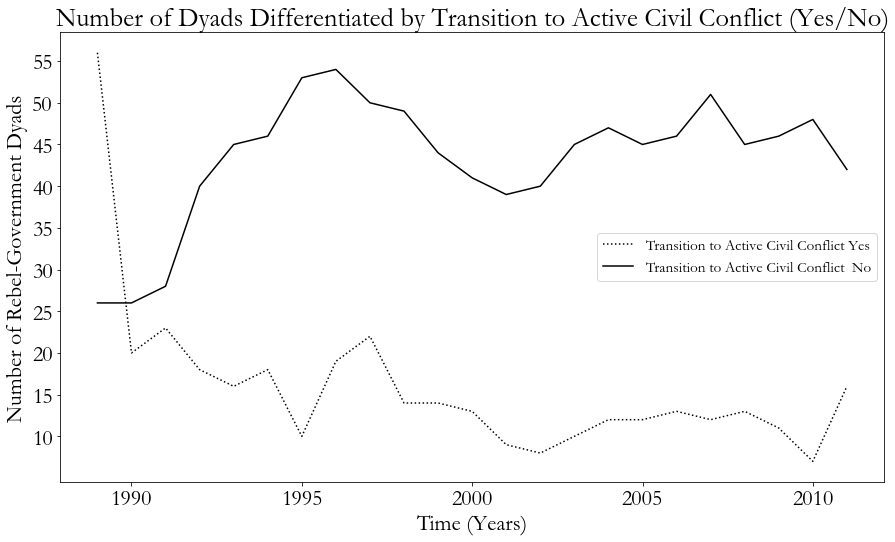

In [27]:
### Plot proportion of onset variable (drop version) (yes/no) over time  ------

# Prepare dataset, summarize active_year_onset_drop over time and differentiated by 0/1
time_prop = pd.DataFrame(sorted(df_s.year.unique()))
time_prop["active_no"] = list(df_s.groupby('year')['active_year_onset_drop'].apply(lambda x: (x==0).sum()))
time_prop["active_yes"] = list(df_s.groupby('year')['active_year_onset_drop'].apply(lambda x: (x==1).sum()))
time_prop.columns = ["year", "active_no", "active_yes"]

# Plot results
fig = plt.figure(figsize=(13, 8))
ax = plt.axes()
ax.plot(time_prop["year"],time_prop["active_yes"], label = "Transition to Active Civil Conflict Yes",  color="black", linestyle="dotted");    
ax.plot(time_prop["year"],time_prop["active_no"], label = "Transition to Active Civil Conflict  No", color="black", linestyle="solid");
ax.legend(prop={'size': 15}, loc= 'center right')
ax.set_yticks(np.arange(10, 60, 5))
ax.set(xlabel='Time (Years)', ylabel='Number of Rebel-Government Dyads', title=f'Number of Dyads Differentiated by Transition to Active Civil Conflict (Yes/No)')

# Save plot
fig.savefig(os.path.join(out_paths["desciptive_plots_outcome"], f"_all_sample_onset"), dpi=100)

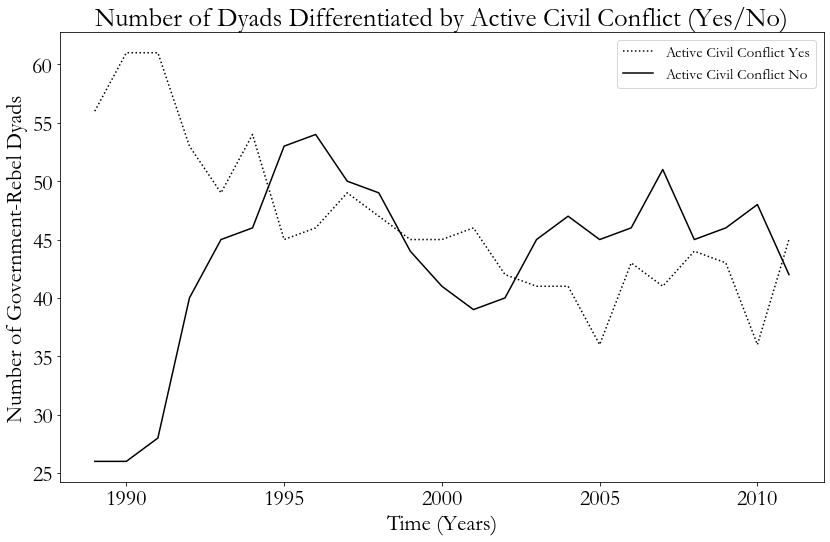

In [28]:
### Plot proportion of active (yes/no) over time  ------

# Prepare dataset, summarize active_year over time and differentiated by 0/1
time_prop = pd.DataFrame(sorted(df.year.unique()))
time_prop["active_no"] = list(df.groupby('year')['active_year'].apply(lambda x: (x==0).sum()))
time_prop["active_yes"] = list(df.groupby('year')['active_year'].apply(lambda x: (x==1).sum()))
time_prop.columns = ["year", "active_no", "active_yes"]

# Plot results
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(time_prop["year"],time_prop["active_yes"], label = "Active Civil Conflict Yes",  color="black", linestyle="dotted");    
ax.plot(time_prop["year"],time_prop["active_no"], label = "Active Civil Conflict No", color="black", linestyle="solid");
ax.legend(prop={'size': 15}, loc= 'upper right')
ax.set(xlabel='Time (Years)', ylabel='Number of Government-Rebel Dyads', title=f'Number of Dyads Differentiated by Active Civil Conflict (Yes/No)') 

# Save plot
fig.savefig(os.path.join(out_paths["desciptive_plots_outcome"], f"_all_sample"), dpi=100)

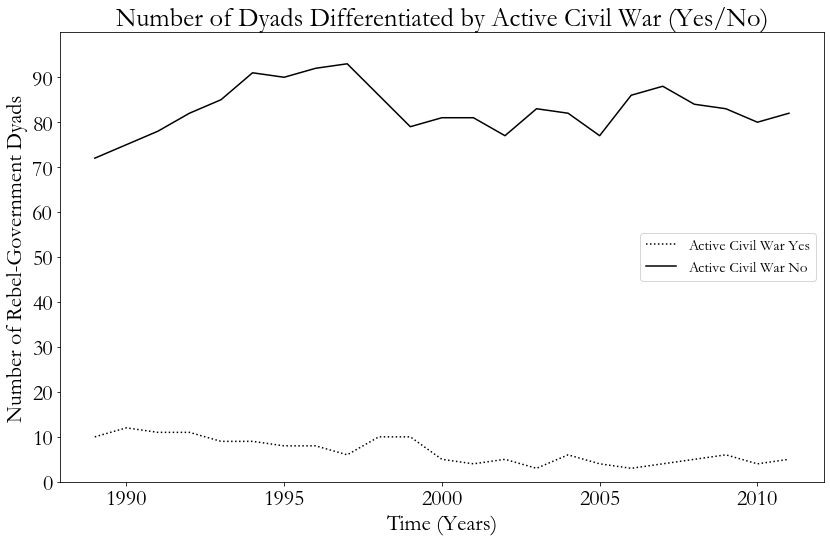

In [29]:
### Plot proportion of Civil War (yes/no) over time  ------

# Subset data for active civil war yes and summarize over year
out_war = df.loc[df['best']>=1000]
out_war_col = out_war.groupby('year')['StateAbb'].agg({'count'})

# Subset data for active civil war no and summarize over year
out_no_war = df.loc[df['best']<1000]
out_no_war_col = out_no_war.groupby('year')['StateAbb'].agg({'count'})

# Save in data frame
time_prop = pd.concat([out_war_col, out_no_war_col], axis=1)
time_prop.reset_index(inplace=True)
time_prop.columns = [ "year", "sum_war", "sum_no_war"]


# Plot results
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(time_prop["year"],time_prop["sum_war"], label = "Active Civil War Yes",  color="black", linestyle="dotted");   
ax.plot(time_prop["year"],time_prop["sum_no_war"], label = "Active Civil War No", color="black", linestyle="solid");
ax.set_ylim([0, 100])
ax.set_yticks(np.arange(0, 100, 10))
ax.legend(prop={'size': 15}, loc= 'center right')
ax.set(xlabel='Time (Years)', ylabel='Number of Rebel-Government Dyads', title=f'Number of Dyads Differentiated by Active Civil War (Yes/No)') 

# Save plot
fig.savefig(os.path.join(out_paths["desciptive_plots_outcome"], f"_civil_war_"), dpi=100)

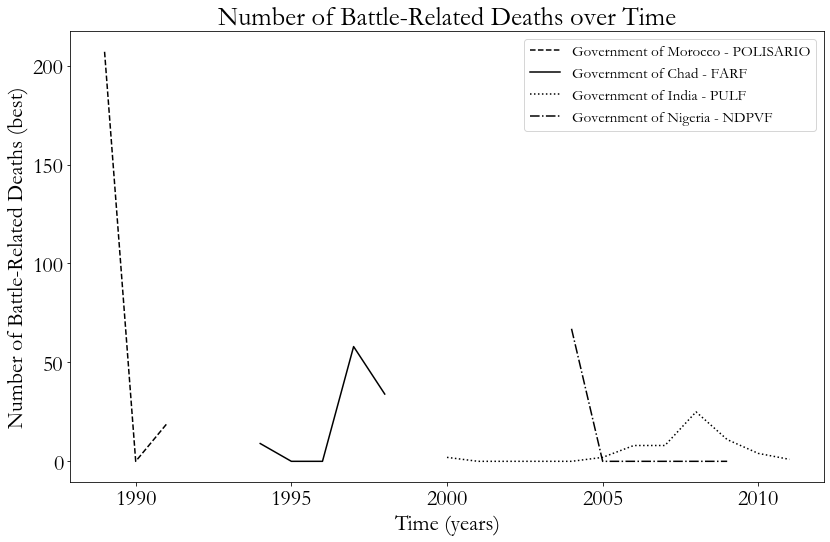

In [30]:
### Plot a few selected dyads to show data structure -----
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

# Select dyads
ax.plot(df["year"].loc[df["dyad_name"]=="Government of Morocco - POLISARIO"],
        df["best"].loc[df["dyad_name"]=="Government of Morocco - POLISARIO"], color="black", linestyle="dashed",
        label = "Government of Morocco - POLISARIO");
ax.plot(df["year"].loc[df["dyad_name"]=="Government of Chad - FARF"],
        df["best"].loc[df["dyad_name"]=="Government of Chad - FARF"], color="black", linestyle="solid",
        label = "Government of Chad - FARF");
ax.plot(df["year"].loc[df["dyad_name"]=="Government of India - PULF"],
        df["best"].loc[df["dyad_name"]=="Government of India - PULF"], color="black", linestyle=':',
        label = "Government of India - PULF");
ax.plot(df["year"].loc[df["dyad_name"]=="Government of Nigeria - NDPVF"],
        df["best"].loc[df["dyad_name"]=="Government of Nigeria - NDPVF"], color="black", linestyle='-.',
        label = "Government of Nigeria - NDPVF");

ax.set(xlabel='Time (years)', ylabel='Number of Battle-Related Deaths (best)', title=f'Number of Battle-Related Deaths over Time') 
ax.legend(bbox_to_anchor=(1, 1), prop={'size': 15})

# Save plot
fig.savefig(os.path.join(out_paths["desciptive_plots_outcome"], f"_entry_exit"), dpi=100)

In [31]:
### Function to get summary table -----
def summary_tab(df,
               features):
    # Divide dataset on the basis of the outcome 
    df_active = df.loc[df['active_year_onset_drop']==1]
    df_not_active = df.loc[df['active_year_onset_drop']==0]
    
    # Make empty data table
    sum_tab = pd.DataFrame(columns=["Feature", "Transition No", "Transition Yes"])
    
    # For each variable get mean/median and append to empty dataset
    for i in features:
        feat_long=[]
        feat_long.append(dict_feat_names[i]) # add fancy names
        feat_long.append(str(round(df_not_active[i].mean(),3)))
        feat_long.append(f"({round(df_not_active[i].median(),3)})")
        feat_long.append(str(round(df_active[i].mean(), 3)))
        feat_long.append(f"({round(df_active[i].median(), 3)})")

        # Transpose data frame and join mean/median columns
        feat_long = pd.DataFrame(feat_long).T
        feat_long['mean_median_no'] = feat_long[[1, 2]].agg(' '.join, axis=1)
        feat_long['mean_median_yes'] = feat_long[[3, 4]].agg(' '.join, axis=1)
        
        # Subset dataset and rename columns
        feat_long_s = feat_long[[0, "mean_median_no", "mean_median_yes"]]
        feat_long_s=feat_long_s.rename(columns={0: "Feature", "mean_median_no": "Transition No", "mean_median_yes": "Transition Yes"})
        
        # merge with base dataset
        sum_tab = pd.concat([sum_tab, feat_long_s], axis=0)
        
    return sum_tab

In [32]:
### Get summary table for involved variables ---
pd.options.display.float_format = '{:.3f}'.format   

sum_tab= summary_tab(df=df_s,
    features= feat_state_capacity + feat_rebel_visibility +  ["goal_total",
    "ideo_total",
    "ident_ethnicity",
    "parent_splinter_nonstate",
    "parent_splinter_state",
    "parent_civil_society",
    "parent_merger",
    "internet_use",
    "oil",])
                                                                     
# Save table 
sum_tab.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"_sum_tab.tex"), index=False)
sum_tab

,Feature,Transition No,Transition Yes
0,Quality of Government,0.485 (0.451),0.414 (0.405)
0,Military Expenditure Index,1.817 (1.78),1.797 (1.777)
0,Military Personnel Index,1.116 (1.04),1.117 (1.119)
0,Combined Polity Score,1.645 (3.0),0.17 (0.0)
0,Location of Rebel Group Formation to Capital,3.787 (3.0),3.672 (3.0)
0,Forest Coverage,28.8 (23.25),26.492 (22.958)
0,Rural Population,55.099 (63.924),60.11 (65.816)
0,Terrain Ruggedness,151.771 (167.3),137.105 (101.3)
0,Age of Rebel Group Since Formation,19.648 (17.0),11.016 (7.0)
0,Intensity of Goals,1.402 (1.0),1.443 (1.0)


In [33]:
### Check manually ----
print(df_s["goal_total"].loc[df_s['active_year_onset_drop']==1].mean())
print(df_s["goal_total"].loc[df_s['active_year_onset_drop']==0].mean())
print(df_s["goal_total"].loc[df_s['active_year_onset_drop']==1].median())
print(df_s["goal_total"].loc[df_s['active_year_onset_drop']==0].median())

1.4426229508196722
1.4016064257028114
1.0
1.0


In [34]:
### Value frequency (complete dataset) -----
print(df[df.active_year == 0].shape[0]) # 
print(df[df.active_year == 1].shape[0]) #

996
1069


In [35]:
### Value frequency (complete dataset) -----
print(df[df.active_year_onset == 0].shape[0]) # 
print(df[df.active_year_onset == 1].shape[0]) #

1699
366


In [36]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df[df.active_year_onset_drop == 0].shape[0]) # 
print(df[df.active_year_onset_drop == 1].shape[0]) #
print(df[df.active_year_onset_drop == -99].shape[0]) #

996
366
703


In [37]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s[df_s.active_year_onset_drop == 0].shape[0]) # 
print(df_s[df_s.active_year_onset_drop == 1].shape[0]) #

996
366


In [38]:
### Summary statistics (complete dataset) -----
print(df["gov_qual"].min())
print(df["gov_qual"].max())
print(df["gov_qual"].mean())
print(df["gov_qual"].median())

0.055555556
0.94444442
0.45580189544584354
0.42129629999999996


In [39]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["gov_qual"].min())
print(df_s["gov_qual"].max())
print(df_s["gov_qual"].mean())
print(df_s["gov_qual"].median())

0.055555556
0.94444442
0.46618091360345154
0.43055555


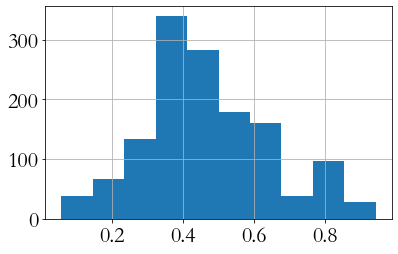

In [40]:
### Plot distribution ----
df_s["gov_qual"].hist()

In [41]:
### Summary statistics (complete dataset) -----
print(df["milexp_in"].min())
print(df["milexp_in"].max())
print(df["milexp_in"].mean())
print(df["milexp_in"].median())

0.0
5.48
1.8117475391888331
1.79


In [42]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["milexp_in"].min())
print(df_s["milexp_in"].max())
print(df_s["milexp_in"].mean())
print(df_s["milexp_in"].median())

0.0
5.48
1.8116859983762512
1.78


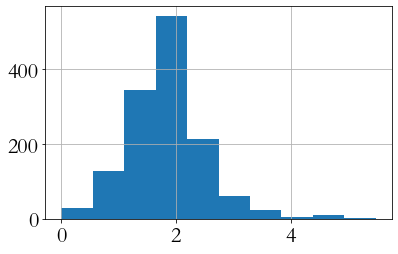

In [43]:
### Plot distribution ----
df_s["milexp_in"].hist()

In [44]:
### Summary statistics (complete dataset) -----
print(df["milper_in"].min())
print(df["milper_in"].max())
print(df["milper_in"].mean())
print(df["milper_in"].median())

0.0
6.3800000999999975
1.1159100018514274
1.0951060117985734


In [45]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["milper_in"].min())
print(df_s["milper_in"].max())
print(df_s["milper_in"].mean())
print(df_s["milper_in"].median())

0.0
6.3800000999999975
1.1160405734608738
1.0700001000000001


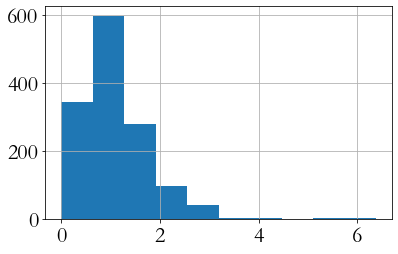

In [46]:
### Plot distribution ----
df_s["milper_in"].hist()

In [47]:
### Summary statistics (complete dataset) -----
print(df["polity2"].min())
print(df["polity2"].max())
print(df["polity2"].mean())
print(df["polity2"].median())

-9.0
10.0
1.3030318573929602
1.0


In [48]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["polity2"].min())
print(df_s["polity2"].max())
print(df_s["polity2"].mean())
print(df_s["polity2"].median())

-9.0
10.0
1.2484211972121848
1.0


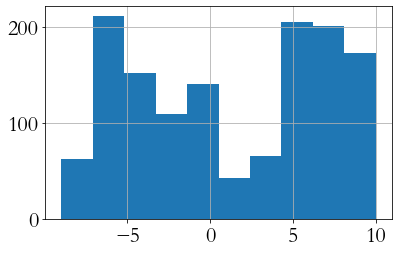

In [49]:
### Plot distribution ----
df_s["polity2"].hist()

In [50]:
### Value frequency (complete dataset) -----
print(df[df.foundloc_cat_cat == 1].shape[0]) # 
print(df[df.foundloc_cat_cat == 2].shape[0]) # 
print(df[df.foundloc_cat_cat == 3].shape[0]) # 
print(df[df.foundloc_cat_cat == 4].shape[0]) # 
print(df[df.foundloc_cat_cat == 5].shape[0]) # 
print(df[df.foundloc_cat_cat == 6].shape[0]) # 
print(df[df.foundloc_cat_cat == 7].shape[0]) # 
print(df[df.foundloc_cat_cat == 8].shape[0]) # 

163
493
760
92
76
223
51
207


In [51]:
### Value frequency (truncated version based on conflict onset variable)  -----
print(df_s[df_s.foundloc_cat_cat == 1].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 2].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 3].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 4].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 5].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 6].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 7].shape[0]) # 
print(df_s[df_s.foundloc_cat_cat == 8].shape[0]) # 

111
315
486
54
49
144
32
171


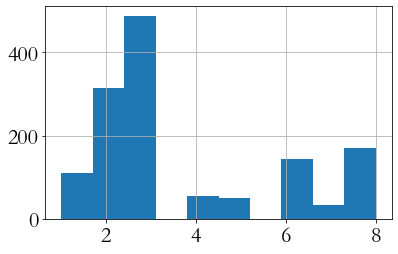

In [52]:
### Plot distribution ----
df_s["foundloc_cat_cat"].hist() 

In [53]:
### Summary statistics (complete dataset) -----
print(df["age_formation"].min())
print(df["age_formation"].max())
print(df["age_formation"].mean())
print(df["age_formation"].median())

-14.0
66.0
17.076513317191285
14.0


In [54]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["age_formation"].min())
print(df_s["age_formation"].max())
print(df_s["age_formation"].mean())
print(df_s["age_formation"].median())

-14.0
66.0
17.32819383259912
14.0


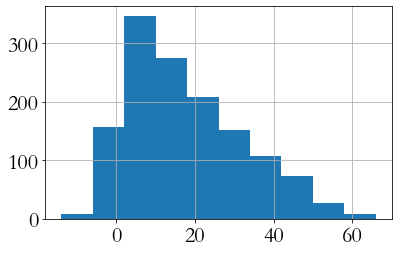

In [55]:
### Plot distribution ----
df_s["age_formation"].hist() 
# negative values make sense since "Year of rebel group’s formation" is differently defined in FORGE data as in the analysis of the thesis
# the official "formation" could come later than "violence leading to at least one fatality"
# values which are negative could be re-coded as 0 to align FORGE conceptualization with the theoretical framework of the thesis
# however, there are so few observations that it does not appear necessary

In [56]:
### Summary statistics (complete dataset)  -----
print(df["terrain"].min())
print(df["terrain"].max())
print(df["terrain"].mean())
print(df["terrain"].median())

11.5
620.2
145.14479418886012
134.7


In [57]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["terrain"].min())
print(df_s["terrain"].max())
print(df_s["terrain"].mean())
print(df_s["terrain"].median())

11.5
620.2
147.82995594713614
157.0


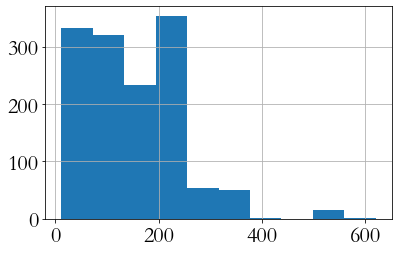

In [58]:
### Plot distribution ----
df_s["terrain"].hist()  

In [59]:
### Summary statistics (complete dataset)  -----
print(df["forest_cov"].min())
print(df["forest_cov"].max())
print(df["forest_cov"].mean())
print(df["forest_cov"].median())

0.0440102466221307
88.5095514950166
27.834394729005215
23.1179305728864


In [60]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["forest_cov"].min())
print(df_s["forest_cov"].max())
print(df_s["forest_cov"].mean())
print(df_s["forest_cov"].median())

0.0440102466221307
88.5095514950166
28.179633661750206
23.214039466028098


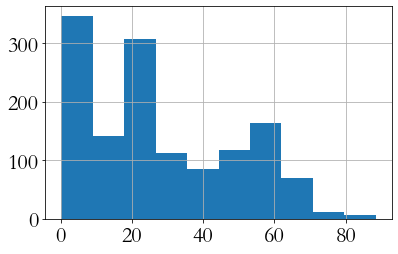

In [61]:
### Plot distribution ----
df_s["forest_cov"].hist()  

In [62]:
### Value frequency (complete dataset) -----
print(df["parent_splinter_nonstate"].min())
print(df["parent_splinter_nonstate"].max())
print(df["parent_splinter_nonstate"].mean())
print(df["parent_splinter_nonstate"].median())
print(df[df.parent_splinter_nonstate == 0].shape[0]) # 
print(df[df.parent_splinter_nonstate == 1].shape[0]) #

0.0
1.0
0.5980629539951574
1.0
830
1235


In [63]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s["parent_splinter_nonstate"].min())
print(df_s["parent_splinter_nonstate"].max())
print(df_s["parent_splinter_nonstate"].mean())
print(df_s["parent_splinter_nonstate"].median())
print(df_s[df_s.parent_splinter_nonstate == 0].shape[0]) # 
print(df_s[df_s.parent_splinter_nonstate == 1].shape[0]) #

0.0
1.0
0.5983847283406755
1.0
547
815


In [64]:
### Value frequency (complete dataset) -----
print(df["parent_splinter_state"].min())
print(df["parent_splinter_state"].max())
print(df["parent_splinter_state"].mean())
print(df["parent_splinter_state"].median())
print(df[df.parent_splinter_state == 0].shape[0]) # 
print(df[df.parent_splinter_state == 1].shape[0]) #

0.0
1.0
0.0891041162227603
0.0
1881
184


In [65]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s["parent_splinter_state"].min())
print(df_s["parent_splinter_state"].max())
print(df_s["parent_splinter_state"].mean())
print(df_s["parent_splinter_state"].median())
print(df_s[df_s.parent_splinter_state == 0].shape[0]) # 
print(df_s[df_s.parent_splinter_state == 1].shape[0]) #

0.0
1.0
0.08883994126284875
0.0
1241
121


In [66]:
### Value frequency (complete dataset) -----
print(df["parent_civil_society"].min())
print(df["parent_civil_society"].max())
print(df["parent_civil_society"].mean())
print(df["parent_civil_society"].median())
print(df[df.parent_civil_society == 0].shape[0]) # 
print(df[df.parent_civil_society == 1].shape[0]) #

0.0
1.0
0.3215496368038741
0.0
1401
664


In [67]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s["parent_civil_society"].min())
print(df_s["parent_civil_society"].max())
print(df_s["parent_civil_society"].mean())
print(df_s["parent_civil_society"].median())
print(df_s[df_s.parent_civil_society == 0].shape[0]) # 
print(df_s[df_s.parent_civil_society == 1].shape[0]) #

0.0
1.0
0.276798825256975
0.0
985
377


In [68]:
### Value frequency (complete dataset) -----
print(df["parent_merger"].min())
print(df["parent_merger"].max())
print(df["parent_merger"].mean())
print(df["parent_merger"].median())
print(df[df.parent_merger == 0].shape[0]) # 
print(df[df.parent_merger == 1].shape[0]) #

0.0
1.0
0.26634382566585957
0.0
1515
550


In [69]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s["parent_merger"].min())
print(df_s["parent_merger"].max())
print(df_s["parent_merger"].mean())
print(df_s["parent_merger"].median())
print(df_s[df_s.parent_merger == 0].shape[0]) # 
print(df_s[df_s.parent_merger == 1].shape[0]) #

0.0
1.0
0.25036710719530103
0.0
1021
341


In [70]:
### Value frequency (complete dataset) -----
print(df["ident_ethnicity"].min())
print(df["ident_ethnicity"].max())
print(df["ident_ethnicity"].mean())
print(df["ident_ethnicity"].median())
print(df[df.ident_ethnicity == 0].shape[0]) # 
print(df[df.ident_ethnicity == 1].shape[0]) #

0.0
1.0
0.6077481840193705
1.0
810
1255


In [71]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s["ident_ethnicity"].min())
print(df_s["ident_ethnicity"].max())
print(df_s["ident_ethnicity"].mean())
print(df_s["ident_ethnicity"].median())
print(df_s[df_s.ident_ethnicity == 0].shape[0]) # 
print(df_s[df_s.ident_ethnicity == 1].shape[0]) #

0.0
1.0
0.643906020558003
1.0
485
877


In [72]:
### Summary statistics (complete dataset)  -----
print(df["ideo_total"].min())
print(df["ideo_total"].max())
print(df["ideo_total"].mean())
print(df["ideo_total"].median())

0.0
3.0
1.1181598062953995
1.0


In [73]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["ideo_total"].min())
print(df_s["ideo_total"].max())
print(df_s["ideo_total"].mean())
print(df_s["ideo_total"].median())

0.0
3.0
1.1226138032305433
1.0


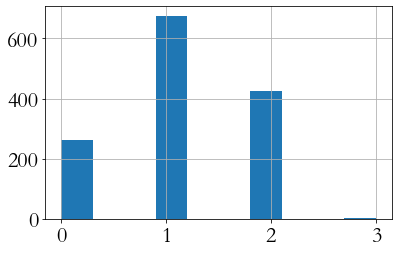

In [74]:
### Plot distribution ----
df_s["ideo_total"].hist() 

In [75]:
### Value frequency (complete dataset) -----
print(df[df.ideo_total == 0].shape[0]) # 
print(df[df.ideo_total == 1].shape[0]) #
print(df[df.ideo_total == 2].shape[0]) #
print(df[df.ideo_total == 3].shape[0]) # very few observations

368
1089
604
4


In [76]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s[df_s.ideo_total == 0].shape[0]) # 
print(df_s[df_s.ideo_total == 1].shape[0]) #
print(df_s[df_s.ideo_total == 2].shape[0]) #
print(df_s[df_s.ideo_total == 3].shape[0]) #

262
673
425
2


In [77]:
### Summary statistics (complete dataset)  -----
print(df["goal_total"].min())
print(df["goal_total"].max())
print(df["goal_total"].mean())
print(df["goal_total"].median())

1.0
4.0
1.4145278450363197
1.0


In [78]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["goal_total"].min())
print(df_s["goal_total"].max())
print(df_s["goal_total"].mean())
print(df_s["goal_total"].median())

1.0
4.0
1.4126284875183555
1.0


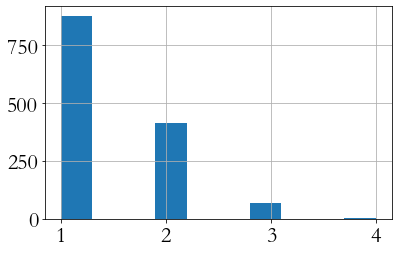

In [79]:
### Plot distribution ----
df_s["goal_total"].hist() 

In [80]:
### Value frequency (complete dataset) -----
print(df[df.goal_total == 1].shape[0]) # 
print(df[df.goal_total == 2].shape[0]) #
print(df[df.goal_total == 3].shape[0]) #
print(df[df.goal_total == 4].shape[0]) #

1320
637
105
3


In [81]:
### Value frequency (truncated version based on conflict onset variable) -----
print(df_s[df_s.goal_total == 1].shape[0]) # 
print(df_s[df_s.goal_total == 2].shape[0]) #
print(df_s[df_s.goal_total == 3].shape[0]) #
print(df_s[df_s.goal_total == 4].shape[0]) #

875
415
69
3


In [82]:
### Summary statistics (complete dataset)  -----
print(df["internet_use"].min())
print(df["internet_use"].max())
print(df["internet_use"].mean())
print(df["internet_use"].median())

0.0
85.37999855
4.745336007353271
0.497929361


In [83]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["internet_use"].min())
print(df_s["internet_use"].max())
print(df_s["internet_use"].mean())
print(df_s["internet_use"].median())

0.0
85.37999855
5.041194363151
0.8472245209999999


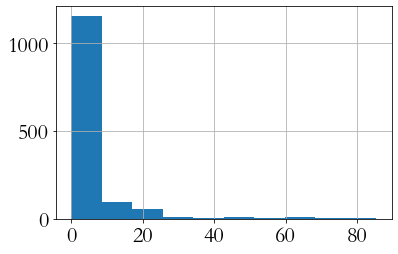

In [84]:
### Plot distribution ----
df_s["internet_use"].hist() # extremely right-skewed

In [85]:
### Summary statistics (complete dataset)  -----
print(df["oil"].min())
print(df["oil"].max())
print(df["oil"].mean())
print(df["oil"].median())

0.0
66.5640813229259
5.738932509570111
0.8749240080107242


In [86]:
### Summary statistics (truncated version based on conflict onset variable) -----
print(df_s["oil"].min())
print(df_s["oil"].max())
print(df_s["oil"].mean())
print(df_s["oil"].median())

0.0
66.5640813229259
6.001550562648924
0.8908314450570931


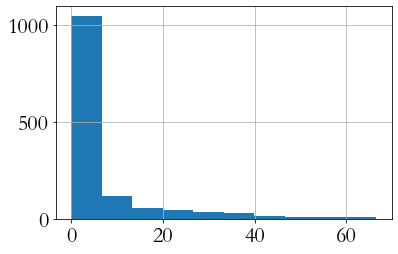

In [87]:
### Plot distribution ----
df_s["oil"].hist()  # extremely right-skewed

In [88]:
### Which variables are in data -------------
dat_var = []
for col in df.columns:
    dat_var.append(col)
dat_var

['year',
 'StateAbb',
 'ccode',
 'cname',
 'side_a',
 'side_a_new_id',
 'side_b',
 'side_b_new_id',
 'dyad_name',
 'dyad_new_id',
 'active_year',
 'best',
 'high',
 'low',
 'foundloc',
 'foundyear',
 'foundmo',
 'foundday',
 'fightyear',
 'fightmo',
 'fightday',
 'goalnominal',
 'goalindep',
 'goalauto',
 'goalrights',
 'goalrep',
 'goalchange',
 'goaldem',
 'goalother',
 'goalnote',
 'ideology',
 'ideolcom',
 'ideolleft',
 'ideolright',
 'ideolnat',
 'ideolanti',
 'ideolrel',
 'ideoloth',
 'ideolnote',
 'religious',
 'religion',
 'ethnic',
 'ethnicity',
 'preorg',
 'preorgno',
 'preorgreb',
 'preorgter',
 'preorgpar',
 'preorgmvt',
 'preorgyou',
 'preorglab',
 'preorgmil',
 'preorggov',
 'preorgfmr',
 'preorgrel',
 'preorgfor',
 'preorgref',
 'preorgeth',
 'preorgoth',
 'preorgname',
 'merger',
 'splinter',
 'splinterUCDP',
 'foundloc_cat',
 'foundloc_cat_lab',
 'foundloc_cat_cat_lab',
 'age_active',
 'goal_territory',
 'goal_gov_represent',
 'goal_gov_replace',
 'ideo_left',
 'ideo_r

In [89]:
### Reset index -----------
df.reset_index(drop=True, inplace=True)
print(len(df))
df.head(3)

2065


,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,gov_qual,milexp_in,milper_in,polity2,internet_use,active_year_lag,active_year_onset,active_year_onset_drop,active_roll,civil_war_dummy
0,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.306,1.814,1.208,-6.000,4.261,0.000,0,0,0,0
1,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.306,1.840,0.520,-6.000,0.000,0.000,1,1,1,0
2,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,0.370,1.520,0.520,-6.000,0.000,1.000,0,0,1,0


In [90]:
### Save dataset which includes coding of outcome variables  ------
df.to_csv(os.path.join(out_paths["data"], f"df_imp_1_onset.csv"), index=False, sep=',')
#df.to_csv(os.path.join(out_paths["data"], f"df_imp_simple_interpolated_onset.csv"), index=False, sep=',')
len(df)

2065